In [67]:
import spot
import buddy
from spot.jupyter import display_inline, display
from IPython.core.display import HTML
spot.setup(show_default='.a')
print('Spot version ', spot.version())

Spot version  2.11.4


# Construct NBA

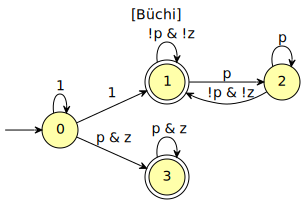

In [68]:
nba = spot.automaton("""
HOA: v1
States: 4
Start: 0
AP: 2 "p" "z"
acc-name: Buchi
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc stutter-invariant
--BODY--
State: 0
[t] 0
[t] 1
[0&1] 3
State: 1 {0}
[!0&!1] 1
[0] 2
State: 2
[0] 2
[!0&!1] 1
State: 3 {0}
[0&1] 3
--END--
""")
nba

In [69]:
inputs = ["p"]
outputs = ["z"]

## By Formula:

In [70]:
# formula = "F(G(!o))"
# f = spot.formula(formula); nba = f.translate('buchi', 'state-based')
# display_inline(nba)

# Unates

In [71]:
def handle_unates(nba):
    for state in range(nba.num_states()):
        for var in outputs:
            varnum = nba.register_ap(var)
            
            ############### Check If Var Is Unate ###############
            positive_unate_sufficient_condition = buddy.bddtrue
            negative_unate_sufficient_condition = buddy.bddtrue
            
            for edge in nba.out(state):
                edge_restrict_positive = buddy.bdd_restrict( edge.cond, buddy.bdd_ithvar(varnum) ) 
                edge_restrict_negative = buddy.bdd_restrict( edge.cond, buddy.bdd_nithvar(varnum) )

                positive_unate_sufficient_condition &= buddy.bdd_imp( edge_restrict_negative, edge_restrict_positive )
                negative_unate_sufficient_condition &= buddy.bdd_imp( edge_restrict_positive, edge_restrict_negative )
            
            ########################## Handle Unateness ################
            if positive_unate_sufficient_condition == buddy.bddtrue:
                print(" => POSITIVE UNATE! State {} , Var {}".format(state, var))
                for edge in nba.out(state):
                    edge.cond = buddy.bdd_restrict( edge.cond, buddy.bdd_ithvar(varnum) ) & buddy.bdd_ithvar(varnum)
            elif negative_unate_sufficient_condition == buddy.bddtrue:
                print(" => NEGATIVE UNATE! State {} , Var {}".format(state, var))
                for edge in nba.out(state):
                    edge.cond = buddy.bdd_restrict( edge.cond, buddy.bdd_nithvar(varnum) ) & buddy.bdd_nithvar(varnum)
            else:
                print(" => UNKNOWN UNATE! State {} , Var {}".format(state, var))


 => POSITIVE UNATE! State 0 , Var z
 => NEGATIVE UNATE! State 1 , Var z
 => NEGATIVE UNATE! State 2 , Var z
 => POSITIVE UNATE! State 3 , Var z


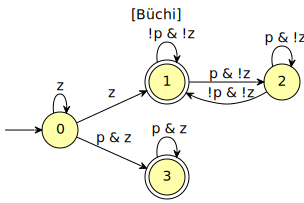

In [72]:
handle_unates(nba)
nba

# Split Input-Outputs

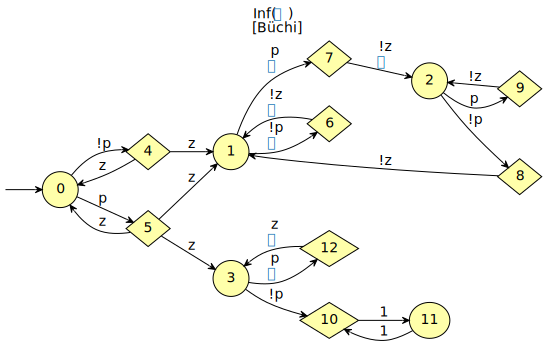

In [73]:
# def nba_to_parity_game(nba):
outs = buddy.bddtrue
for var in outputs:
    varnum = nba.register_ap(var)
    outs &= buddy.bdd_ithvar(varnum)

nba_splitted = spot.split_2step(nba, outs, True)
nba_splitted

# Parity Game

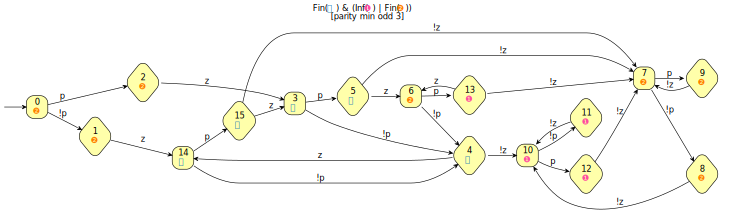

In [74]:
dpa = spot.tgba_determinize(spot.degeneralize_tba(nba_splitted), True, True, True, False)
dpa.merge_states()
dpa = spot.sbacc(dpa)
spot.reduce_parity_here(dpa, True)   # Reduce the parity game to minimal number of colors
spot.alternate_players(dpa)     # Transform an automaton into a parity game by propagating players.
dpa.merge_states()
spot.set_synthesis_outputs(dpa, outs)
dpa

In [75]:
print("Synthesis output vars:")
spot.get_synthesis_output_aps(dpa)

Synthesis output vars:


('z',)

# Synthesis

Found a solution: False


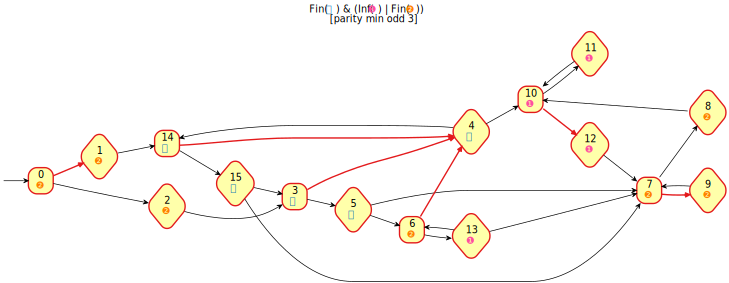

In [76]:
si = spot.synthesis_info()
si.s = spot.synthesis_info.algo_SPLIT_DET
print("Found a solution:", spot.solve_game(dpa, si))
spot.highlight_strategy(dpa)
dpa.show('.g')